# US CPI Inflation Forecasting (Regression)

In [6]:
from fredapi import Fred
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from matplotlib.patches import Patch
from matplotlib.colors import LinearSegmentedColormap

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

from skopt import gp_minimize
from skopt.space import Real, Categorical
from skopt.utils import use_named_args


from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, WhiteKernel, ConstantKernel as C
)

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from hmmlearn import hmm
from hmmlearn import base


from statsmodels.tsa.statespace.dynamic_factor import DynamicFactor
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.statespace.mlemodel import MLEModel
from statsmodels.tsa.statespace.structural import UnobservedComponents

import pymc as pm
import arviz as az

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

## Data

In [2]:
def data():

    # insert on api_key
    fred = Fred(api_key)
    
    series_ids = {
        'CPI': 'CPIAUCSL', # Consumer Price Index
        'PPI': 'PPIACO',  # Producer Price Index
        'NFP' : 'PAYEMS', # Nonfarm Payroll Total
        'PCE': 'PCE',  # Personal Consumption Expenditures
        'Inflation_Expectations': 'MICH',  # Michigan Survey
        'FedFunds_Rate': 'FEDFUNDS',  # Federal Funds Rate
        '10Y_Yield': 'GS10',  # 10-Year Treasury Yield
        'M2': 'M2SL',  # Money Supply M2
        'Federal_Spending': 'FGEXPND',  # Federal Government Spending
    }

    start_date = '1970-01-01'
    end_date = '2024-12-31'
    
    # Download data from FRED
    data = {}
    for name, series_id in series_ids.items():
        data[name] = fred.get_series(series_id, observation_start = start_date, observation_end=end_date)
    
    # Combine into a DataFrame
    df = pd.DataFrame(data)
    df.ffill(inplace=True)

    df['CPI_YOY'] = df['CPI'].pct_change(periods=12) * 100
    df['CPI_YOY_1m_fwd'] = df['CPI_YOY'].shift(-1)
    df['PPI_YOY'] = df['PPI'].pct_change(periods=12) * 100
    df['NFP_MOM'] = df['NFP'] - df['NFP'].shift(1)
    df['PCE_YOY'] = df['PCE'].pct_change(periods=12) * 100
    df['Inflation_Expectations_YOY'] = df['Inflation_Expectations'].pct_change(periods=12) * 100
    df['FedFunds_Rate_YOY'] = df['FedFunds_Rate'].pct_change(periods=12) * 100
    df['Yield_Curve_1Y_Avg'] = (df['10Y_Yield'] - df['FedFunds_Rate']).rolling(12).mean()
    
    df['M2_5Y_Change'] = df['M2'].pct_change(periods=12*5) * 100
    df['Federal_Spending_5Y_Change'] = df['Federal_Spending'].pct_change(periods=12*5) * 100
    
    cols_to_drop = ['CPI','PPI','NFP','PCE','Inflation_Expectations','FedFunds_Rate','10Y_Yield','M2','Federal_Spending']
    df.drop(columns=cols_to_drop, inplace=True)
    df.dropna(inplace=True)
    df.index = df.index.to_period('M').to_timestamp('M')

    return df

### Economic Variables

| **Category**           | **Variable**           | **Data**                                                                 | **Units**                                           | **Frequency** | **Release Schedule**                         |
|------------------------|------------------------|-------------------------------------------------------------------------|----------------------------------------------------|----------------|-----------------------------------------------|
| Cost Push              | Producer Prices        | Producer price index                                                    | Year-over-year change                              | Monthly        | Typically 11th or 13th of the month           |
| Demand Pull            | Non-Farm Payroll       | Non-farm payroll employment                                          Month Year-Month-year change                            | Monthly        | First Friday of the month                     |
|                        | Personal Consumption   | Personal consumption expenditures                                       | Year-over-year change                              | Monthly        | Latter half of month                          |
| Inflation Expectations | Inflation Expectations | Michigan Consumer Survey**                                              | One-year change in one-year-ahead forecas       | Month          | Latter half of month                          |
| Monetary Policy        | Interest Rates         | Federal funds rate                                                      | Year-over-year change                              | Monthly        | Continuous                                    |
|                        | Yield Curve            | 10-year yield minus federal funds rate                                  | One-year moving average                            | Monthly        | Continuous                                    |
|                        | Money Supply           | Money supply M2***                                                      | Five-year change                                   | Monthly        | Latter half of month                          |
| Fiscal Policy          | Federal Spending       | Federal spending****                                                    | Five-year change                                   | Quarterly      | 1 month after quarter-end                    

In [3]:
df = data()

In [4]:
df

,CPI_YOY,CPI_YOY_1m_fwd,PPI_YOY,NFP_MOM,PCE_YOY,Inflation_Expectations_YOY,FedFunds_Rate_YOY,Yield_Curve_1Y_Avg,M2_5Y_Change,Federal_Spending_5Y_Change
1979-01-31,9.250399,9.841270,10.479042,137.0,13.004889,50.000000,50.298507,0.293333,59.544027,69.431460
1979-02-28,9.841270,10.252366,10.962963,247.0,12.006494,45.312500,48.377581,0.109167,59.430687,69.431460
1979-03-31,10.252366,10.485133,11.306902,424.0,11.157895,39.682540,48.600884,-0.075833,59.498908,69.431460
1979-04-30,10.485133,10.697674,11.449275,-62.0,10.169006,44.776119,45.283019,-0.250000,60.625501,66.283710
1979-05-31,10.697674,11.076923,11.510791,372.0,10.396601,42.028986,39.130435,-0.415000,61.239424,66.283710
...,...,...,...,...,...,...,...,...,...,...
2024-07-31,2.938463,2.610914,1.373333,88.0,5.388716,-14.705882,4.101562,-1.002500,42.041943,47.741862
2024-08-31,2.610914,2.432541,-0.860369,71.0,5.252861,-20.000000,0.000000,-1.027500,41.855544,47.741862
2024-09-30,2.432541,2.571403,-2.414515,240.0,5.357190,-15.625000,-3.752345,-1.065833,41.518421,47.741862
2024-10-31,2.571403,2.714168,-0.827220,44.0,5.525577,-35.714286,-9.380863,-1.082500,40.667752,48.236986


In [20]:
# sns.set(style="whitegrid", context="notebook", palette="Set2")


# # Create the pairplot
# pair_grid = sns.pairplot(df,
#                          diag_kind='kde',
#                          corner=True,
#                          plot_kws={'alpha': 0.6, 's': 15, 'edgecolor': 'k'},
#                          diag_kws={'shade': True, 'color': 'skyblue'},
#                         height = 1,
#                         aspect=1.25)

# for ax in pair_grid.axes.flatten():
#     if ax is not None:
#         ax.tick_params(axis='both', labelsize=2)
#         ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
#         ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:,.0f}'))

# plt.suptitle("Pair Plot of Economic Variables", fontsize=14, y=1.03)

# # Tight layout for spacing
# plt.tight_layout()
# #plt.savefig('econs_variable_plot.png', dpi=600, bbox_inches='tight')
# plt.show()

In [4]:
# Split features and target

y_variable = "CPI_YOY_1m_fwd"

X = df.drop(columns=[y_variable])
y = df[y_variable]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## 1. Linear Regression

#### Model
- Assumes a linear relationship:
  $$
  y_i = \mathbf{x}_i^T \boldsymbol{\beta} + \epsilon_i, \quad \epsilon_i \sim \mathcal{N}(0, \sigma^2)
  $$
- The parameters are estimated using Maximum Likelihood or Least Squares.

#### Key Idea
- Fits the best hyperplane to minimize squared error.
- Simple, interpretable baseline for regression.

In [5]:
# Create linear regression object
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on test set
y_pred = model.predict(X_test)

# Calculate RMSE
reg_rmse = np.round(np.sqrt(mean_squared_error(y_test, y_pred)),3)

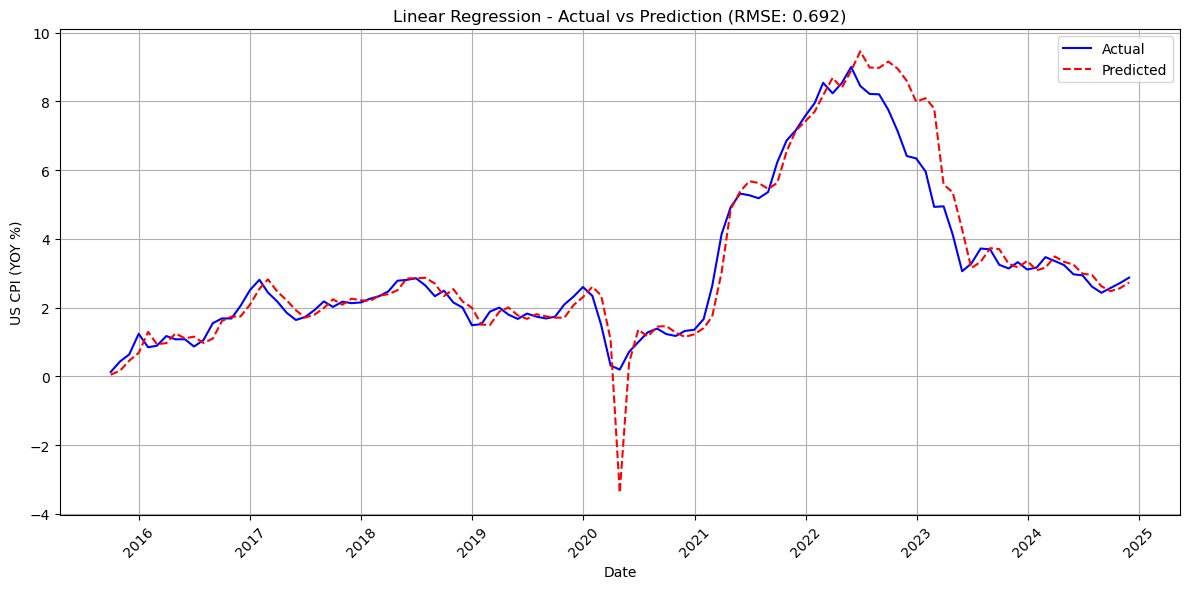

In [6]:
plt.figure(figsize=(12, 6))

test_dates = y_test.index

plt.plot(test_dates, y_test, 'b-', label='Actual')
plt.plot(test_dates, y_pred, 'r--', label='Predicted')
plt.xlabel('Date')
plt.ylabel('US CPI (YOY %)')
plt.title('Linear Regression - Actual vs Prediction (RMSE: {})'.format(reg_rmse))
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2. Lasso Regression

#### Model
- Linear regression with a **Laplace prior** on coefficients:
  $$
  \beta_j \sim \text{Laplace}(0, \lambda^{-1}) \quad \text{(a.k.a. double exponential prior)}
  $$
- Likelihood remains Gaussian:
  $$
  y_i \mid \mathbf{x}_i, \boldsymbol{\beta} \sim \mathcal{N}(\mathbf{x}_i^T \boldsymbol{\beta}, \sigma^2)
  $$

#### Key Idea
- Encourages sparsity in the coefficients — many coefficients shrink to 0.
- Useful for feature selection and regularization.

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
tscv = TimeSeriesSplit(n_splits=5) # since data is sequential, we use TimeSeriesSplit
lasso_cv = LassoCV(alphas=np.logspace(-4, 0, 100), cv = tscv)
lasso_cv.fit(X_train_scaled, y_train)

# 3. Get the optimal alpha and coefficients
optimal_alpha = lasso_cv.alpha_
print(f"Optimal alpha: {optimal_alpha:.4f}")
coefficients = lasso_cv.coef_

Optimal alpha: 0.0890


In [9]:
# Feature Importance
features = X_train.columns
feature_importance = pd.DataFrame({'Feature' : features,
                      'Coef' : abs(coefficients),
                      'Significant': coefficients != 0 })

# Sorted by importance
feature_importance.sort_values(by='Coef', ascending=False)

,Feature,Coef,Significant
0,CPI_YOY,2.662512,True
3,PCE_YOY,0.052186,True
1,PPI_YOY,0.000000,False
2,NFP_MOM,0.000000,False
4,Inflation_Expectations_YOY,0.000000,False
5,FedFunds_Rate_YOY,0.000000,False
6,Yield_Curve_1Y_Avg,0.000000,False
7,M2_5Y_Change,0.000000,False
8,Federal_Spending_5Y_Change,0.000000,False


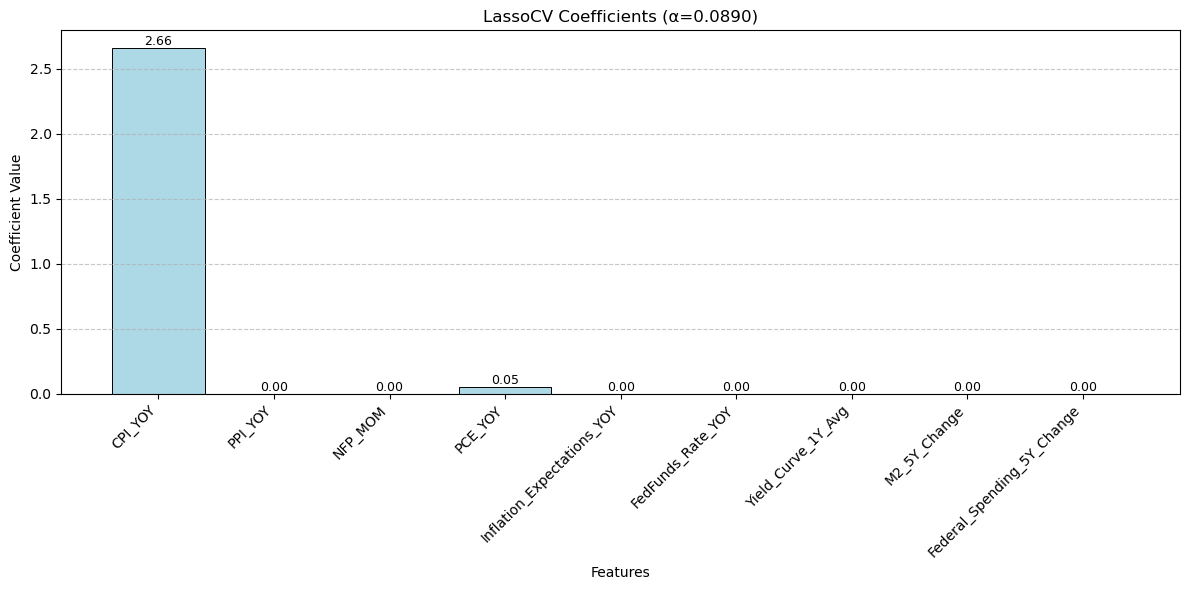

In [10]:
plt.figure(figsize=(12, 6))

# Simple bars with black edges
bars = plt.bar(features, coefficients, 
               color='lightblue', edgecolor='black', linewidth=0.7)

# Add coefficient values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=9)

plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title(f'LassoCV Coefficients (α={optimal_alpha:.4f})')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [11]:
lasso = Lasso(alpha= optimal_alpha)
lasso.fit(X_train_scaled, y_train)
y_pred = lasso.predict(X_test_scaled)

# Calculate RMSE
lasso_rmse = np.round(np.sqrt(mean_squared_error(y_test, y_pred)),3)

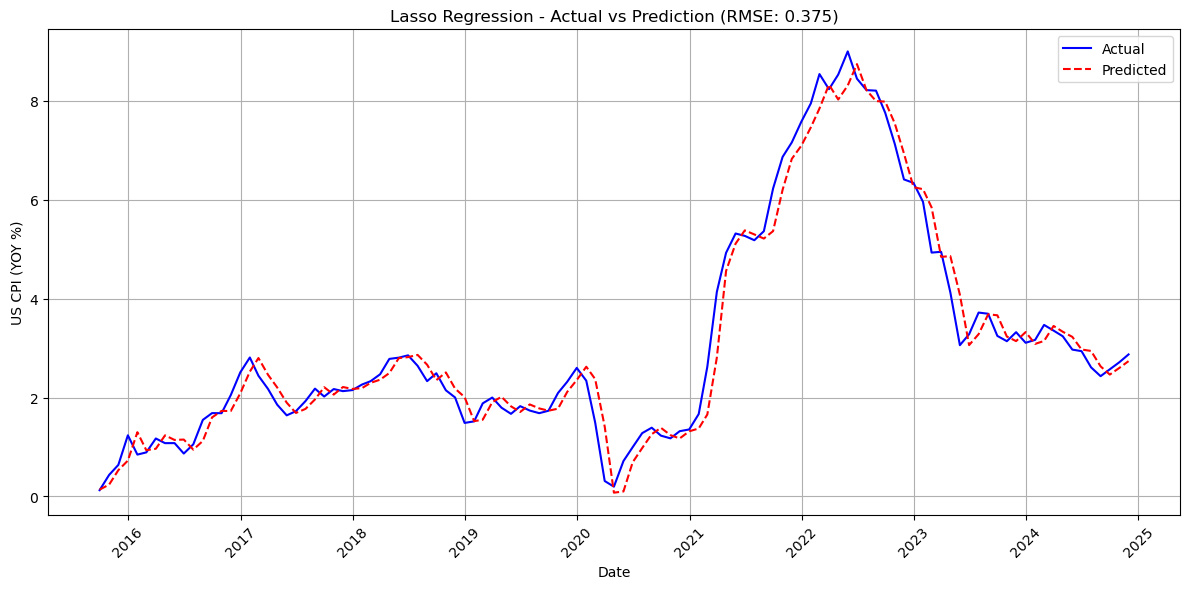

In [12]:
plt.figure(figsize=(12, 6))

test_dates = y_test.index

plt.plot(test_dates, y_test, 'b-', label='Actual')
plt.plot(test_dates, y_pred, 'r--', label='Predicted')
plt.xlabel('Date')
plt.ylabel('US CPI (YOY %)')
plt.title('Lasso Regression - Actual vs Prediction (RMSE: {})'.format(lasso_rmse))
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Gaussian Process Regression

#### Assumptions
- The underlying function f(x) is drawn from a Gaussian Process:
  $$
  f(\mathbf{x}) \sim \mathcal{GP}(0, k(\mathbf{x}, \mathbf{x'}))
  $$
  where the k(x,x') is a covariance/kernel function (e.g., RBF, Matern).

#### Likelihood
- The observed outputs are noisy observations of the latent function:
  $$
  y_i = f(\mathbf{x}_i) + \epsilon_i, \quad \epsilon_i \sim \mathcal{N}(0, \sigma^2)
  $$

#### Posterior Prediction
- For a test point f(x), the predictive distribution is Gaussian:
  $$
  p(f_* \mid \mathbf{x}_*, \mathcal{D}) = \mathcal{N}(\mu_*, \sigma_*^2)
  $$
  where the sigma_2 are computed using the kernel and training data.

#### Key Features
- **Non-parametric**: Doesn’t assume a fixed number of parameters.
- Captures **uncertainty in predictions**.
- Flexible: can model complex nonlinear relationships.
- Expensive at scale: O(N_cube) time complexity.

In [13]:
space = [
    Categorical([
        'RBF','Matern','RationalQuadratic','DotProduct','ExpSineSquared','RBF+ExpSineSquared'], name='kernel_type'),
    
    Real(0.1, 10.0, prior='log-uniform', name='length_scale'),        # For RBF, Matern, etc.
    Real(0.01, 10.0, name='constant_value'),                         # For ConstantKernel
    Real(1e-6, 10, prior='log-uniform', name='noise_level'),        # For WhiteKernel
    Real(0.1, 10.0, name='rq_alpha'),                               # For RationalQuadratic
    Real(1e-2, 50, name='periodicity'),                            # For ExpSineSquared
]

In [14]:
from sklearn.gaussian_process.kernels import *

def make_kernel(kernel_type, length_scale, constant_value, noise_level, rq_alpha, periodicity):
    if kernel_type == 'RBF':
        base = RBF(length_scale=length_scale)
    elif kernel_type == 'Matern':
        base = Matern(length_scale=length_scale, nu=2.5)
    elif kernel_type == 'RationalQuadratic':
        base = RationalQuadratic(length_scale=length_scale, alpha=rq_alpha)
    elif kernel_type == 'DotProduct':
        base = DotProduct()  # No length_scale here
    elif kernel_type == 'ExpSineSquared':
        base = ExpSineSquared(length_scale=length_scale, periodicity=periodicity)
    elif kernel_type == 'RBF+ExpSineSquared':
        base = RBF(length_scale=length_scale) + ExpSineSquared(length_scale=length_scale, periodicity=periodicity)
    
    # Composite kernel with Constant + Noise
    return C(constant_value) * (base + WhiteKernel(noise_level=noise_level))


@use_named_args(space)
def objective(kernel_type, length_scale, constant_value, noise_level, rq_alpha, periodicity):
    try:
        kernel = make_kernel(kernel_type, length_scale, constant_value, noise_level, rq_alpha, periodicity)
        
        gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
        tscv = TimeSeriesSplit(n_splits=5)
        
        # Use time-series k-fold cross-validation with MSE
        score = cross_val_score(gpr, X_train_scaled, y_train, cv= tscv, scoring='neg_mean_squared_error').mean()    
        
        return -score # skopt minimises, so we negate the neg-MSE

    except Exception  as e:
        return 1e6

In [15]:
# Bayesian Optimisation
result = gp_minimize(
    func=objective,
    dimensions=space,
    acq_func='EI',      # Expected Improvement
    n_calls=100,         # Number of evaluations
    random_state=0,
    verbose=True
)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.4202
Function value obtained: 0.2226
Current minimum: 0.2226
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 3.1652
Function value obtained: 0.7492
Current minimum: 0.2226
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 9.1546
Function value obtained: 0.7540
Current minimum: 0.2226
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 2.1434
Function value obtained: 0.5797
Current minimum: 0.2226
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 6.0570
Function value obtained: 0.5915
Current minimum: 0.2226
Iteration No: 6 started. Evaluating

In [16]:
best_params = result.x
best_kernel = make_kernel(*best_params)
print(best_kernel)

0.1**2 * DotProduct(sigma_0=1) + WhiteKernel(noise_level=0.0187)


In [17]:
gp = GaussianProcessRegressor(kernel=best_kernel)

gp.fit(X_train_scaled, y_train)

GaussianProcessRegressor(kernel=0.1**2 * DotProduct(sigma_0=1) + WhiteKernel(noise_level=0.0187))

In [18]:
# Make predictions on the test data
y_pred = gp.predict(X_test_scaled)

In [19]:
# Calculate RMSE
gp_rmse = np.round(np.sqrt(mean_squared_error(y_test, y_pred)),3)
print(gp_rmse)

0.687


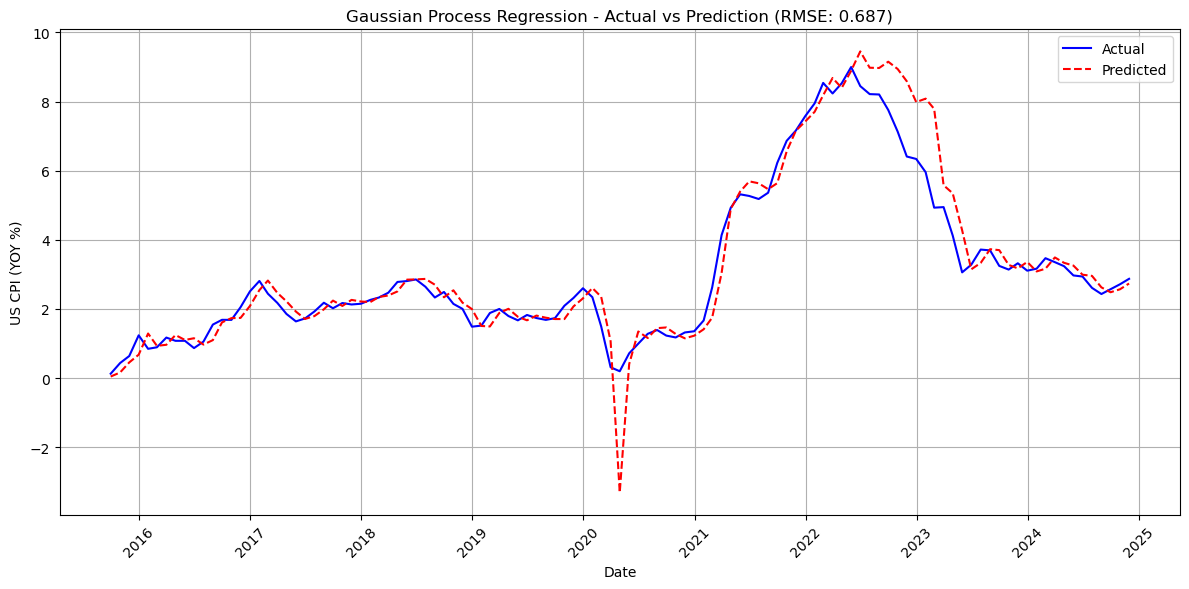

In [20]:
plt.figure(figsize=(12, 6))

test_dates = y_test.index

plt.plot(test_dates, y_test, 'b-', label='Actual')
plt.plot(test_dates, y_pred, 'r--', label='Predicted')
plt.xlabel('Date')
plt.ylabel('US CPI (YOY %)')
plt.title('Gaussian Process Regression - Actual vs Prediction (RMSE: {})'.format(gp_rmse))
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Hidden Markov State Switching Model

#### Model
- Data is assumed to be generated from **K latent regimes**:
  $$
  s_i \in \{1, 2, \dots, K\}, \quad \text{with } P(s_i \mid s_{i-1}) \text{ defined by a transition matrix}
  $$

#### Assumptions
- Data points belong to hidden states, evolving over time as a **Markov chain**:
  $$
  P(s_i \mid s_{i-1}) = A_{s_{i-1}, s_i}
  $$

#### Emission Model (State-dependent Regression)
- For each state \( k \), define a **Lasso regression**:
  $$
  y_i \mid s_i = k, \mathbf{x}_i \sim \mathcal{N}(\mathbf{x}_i^T \boldsymbol{\beta}^{(k)}, \sigma_k^2)
  $$
  $$
  \beta_j^{(k)} \sim \text{Laplace}(0, \lambda^{-1}) \quad \text{(sparse prior)}
  $$

#### Inference
- Use **Expectation-Maximization (EM)** to infer:
  - Hidden states
  - Regression coefficients
  - Transition probabilities between states

#### Key Features
- Captures **temporal structure** and **regime-switching** in time series.
- Each state specializes in modeling part of the data (in this case, lasso for each state)

In [21]:
y_train_reshaped = np.array(y_train).reshape(-1,1)

In [22]:
n_states = range(2,20)

bics = [hmm.GaussianHMM(n, random_state=451).fit(y_train_reshaped).bic(y_train_reshaped) for n in n_states]
optimal_states = n_states[np.argmin(bics)]

In [23]:
optimal_states

4

In [24]:
# Create and train Gaussian HMM
hmm_model = hmm.GaussianHMM(n_components=optimal_states, covariance_type="full", n_iter=300, random_state=451)
hmm_model.fit(y_train_reshaped)

# Predict the most likely hidden states
train_states = hmm_model.predict(y_train_reshaped)

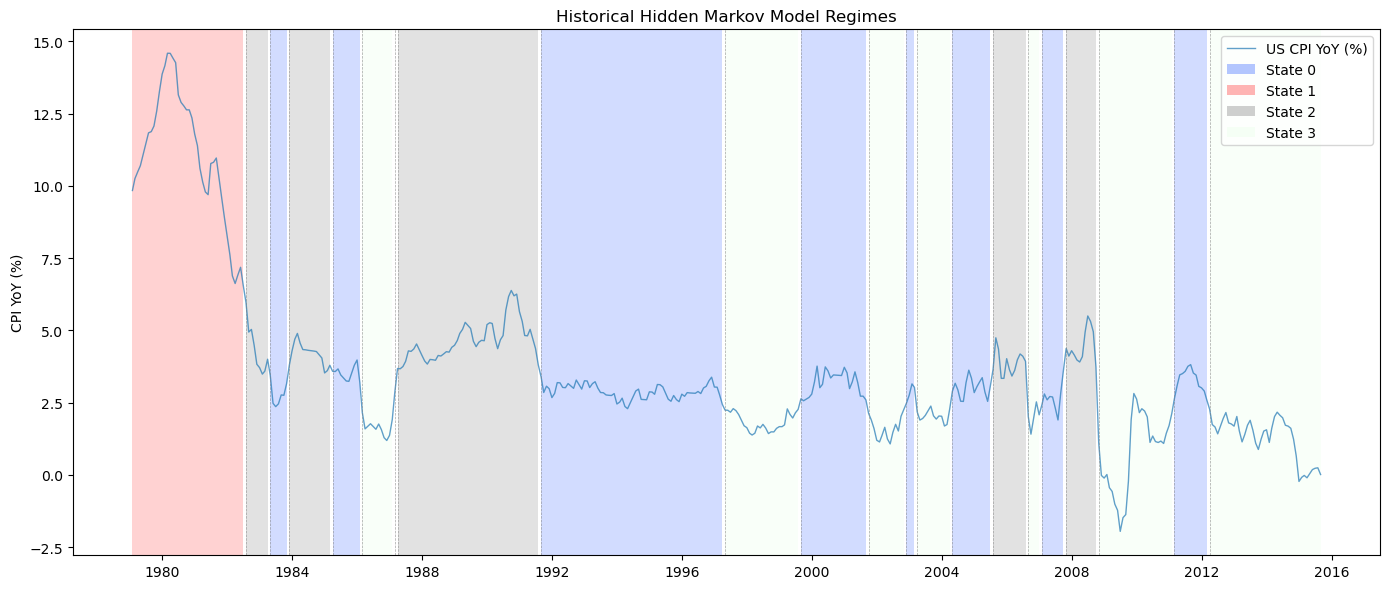

In [25]:
dates = y_train.index

plt.figure(figsize=(14, 6))

main_line = plt.plot(dates, y_train, alpha=0.7, linewidth=1, label='US CPI YoY (%)')[0]

# 2. Prepare state highlighting
#cmap = plt.get_cmap('Pastel1')

cmap = LinearSegmentedColormap.from_list('state_cmap', ['#6B8EFF','#FF6B6B','#A0A0A0','#EEFFEE'], N=4)

unique_states = np.unique(train_states)
state_changes = np.where(np.diff(train_states) != 0)[0] + 1
state_changes = np.concatenate(([0], state_changes, [len(dates)]))

# Create legend handles
legend_elements = [main_line]  # Start with time series line

# 3. Highlight each state
for state in unique_states:
    # Find all intervals for this state
    intervals = []
    for i in range(len(state_changes)-1):
        if train_states[state_changes[i]] == state:
            start = dates[state_changes[i]]
            end = dates[state_changes[i+1]-1]
            intervals.append((start, end))
    
    # Plot all intervals for this state
    for start, end in intervals:
        plt.axvspan(
            start, end,
            facecolor=cmap(state),
            alpha=0.3
        )
    
    # Add to legend (only once per state)
    legend_elements.append(
        Patch(facecolor=cmap(state), alpha=0.5, label=f'State {state}')
    )

# 4. Add state boundaries
for change in state_changes[1:-1]:
    plt.axvline(dates[change], color='gray', linestyle='--', alpha=0.7, linewidth=0.5)

# Formatting
plt.title('Historical Hidden Markov Model Regimes')
plt.ylabel('CPI YoY (%)')

# Create unified legend
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

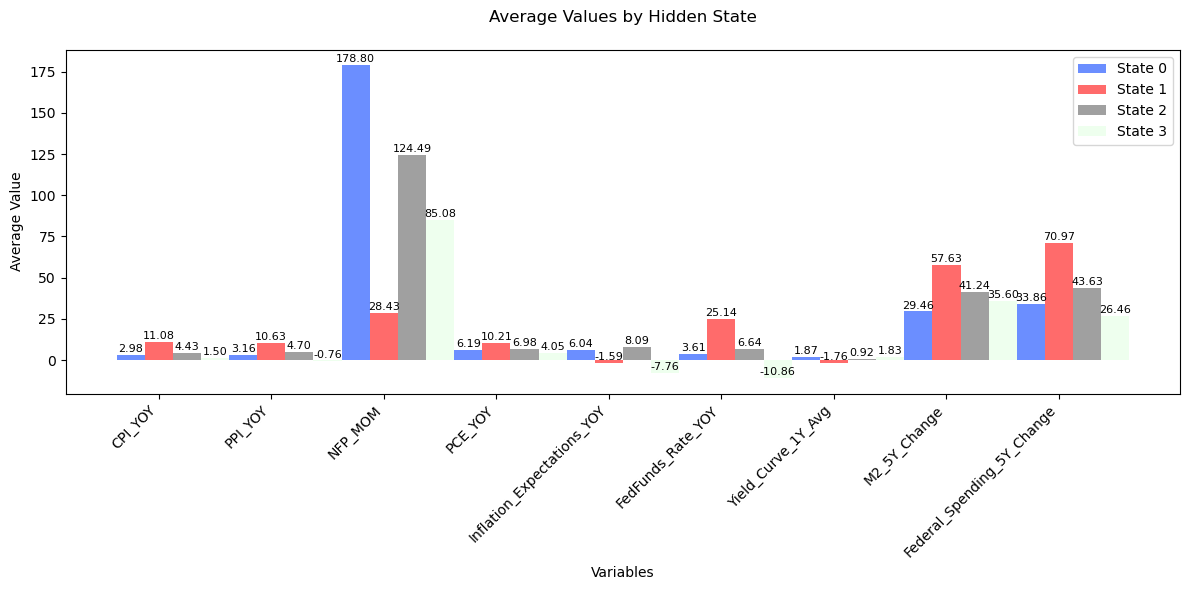

In [26]:
# 1. Combine data with states
data = X_train.copy()
data['State'] = train_states

# 2. Calculate state means
state_means = data.groupby('State').mean().T  # Transpose for better plotting

# 3. Create the visualization
plt.figure(figsize=(12, 6))

# Custom color palette
colors = ['#6B8EFF','#FF6B6B','#A0A0A0','#EEFFEE']

# Plot each variable
n_vars = len(state_means)
bar_width = 0.25
index = np.arange(n_vars)

for i, state in enumerate(state_means.columns):
    plt.bar(
        index + i*bar_width, 
        state_means[state],
        width=bar_width,
        color=colors[i],
        label=f'State {state}'
    )

# Formatting
plt.xlabel('Variables')
plt.ylabel('Average Value')
plt.title('Average Values by Hidden State', pad=20)
plt.xticks(index + bar_width, state_means.index, rotation=45, ha='right')
plt.legend()

# Add value labels
for i, state in enumerate(state_means.columns):
    for j, val in enumerate(state_means[state]):
        plt.text(
            j + i*bar_width, 
            val + 0.01*state_means.values.max(), 
            f'{val:.2f}', 
            ha='center',
            fontsize=8
        )

plt.tight_layout()
plt.show()

In [27]:
state_regressors = {}  # Dictionary to store {state: LassoCV model}
state_coefficients = {}  # To store feature importances

for state in np.unique(train_states):
    mask = (train_states == state)
    X_state = X_train_scaled[mask]
    y_state = y_train[mask]

    tscv = TimeSeriesSplit(n_splits=5) # since data is sequential, we use TimeSeriesSplit
    lasso_cv = LassoCV(alphas=np.logspace(-4, 0, 100), cv = tscv)
    lasso_cv.fit(X_state, y_state)
    
    state_regressors[state] = lasso_cv
    state_coefficients[state] = lasso_cv.coef_
    
    print(f"State {state}: Selected alpha = {lasso_cv.alpha_:.4f}")


State 0: Selected alpha = 0.0152
State 1: Selected alpha = 0.0201
State 2: Selected alpha = 0.0152
State 3: Selected alpha = 0.0015


In [28]:
state_regression_coefficients = pd.DataFrame(state_coefficients).T
state_regression_coefficients.columns = X_train.columns
state_regression_coefficients

,CPI_YOY,PPI_YOY,NFP_MOM,PCE_YOY,Inflation_Expectations_YOY,FedFunds_Rate_YOY,Yield_Curve_1Y_Avg,M2_5Y_Change,Federal_Spending_5Y_Change
0,0.902325,0.086024,-0.020508,0.003857,-0.010502,-0.010981,0.011096,0.065586,-0.001307
1,2.274799,0.443331,0.000000,0.000000,0.171887,0.192799,0.000000,0.000000,-0.000000
2,1.836274,-0.000000,-0.000000,0.077002,0.035873,-0.000000,-0.138834,-0.000000,-0.045390
3,1.734624,0.093215,0.103847,0.139702,0.020521,-0.068178,0.010928,-0.027193,0.049527


In [29]:
def forecast_next_state(hmm_model, last_state, stochastic=False):
    
    transition_probs = hmm_model.transmat_[last_state]

    if stochastic:
        next_state =  np.random.choice(hmm_model.n_components, p=transition_probs)
    else:
        next_state = np.argmax(transition_probs)
        
    return next_state

In [30]:
def hmm_lasso(hmm_model, state_regressors, last_state, X_future):
    """
    Forecast using HMM states and state-specific LassoCV models
    """
    predictions = []
    current_state = last_state

    for x in X_future:
        x = x.reshape(1,-1)
        
        current_state = forecast_next_state(hmm_model, current_state, stochastic=False)

        #print(current_state)
        # Predict with state's Regression model
        if current_state in state_regressors:
            pred = state_regressors[current_state].predict(x)[0]
            predictions.append(pred)
    
    return predictions

def hmm_lasso_ensemble(hmm_model, state_regressors, last_state, X_future, n_simulations=30):
    all_preds = []

    for _ in range(n_simulations):
        preds = []
        current_state = last_state

        for x in X_future:
            x = x.reshape(1, -1)
            current_state = forecast_next_state(hmm_model, current_state, stochastic=True)
            if current_state in state_regressors:
                pred = state_regressors[current_state].predict(x)[0]
            else:
                pred = np.nan  # or fallback to another model
            preds.append(pred)

        all_preds.append(preds)

    return np.nanmean(all_preds, axis=0)

In [31]:
y_pred = hmm_lasso(hmm_model, state_regressors, train_states[-1], X_test_scaled)
y_pred_sim = hmm_lasso_ensemble(hmm_model, state_regressors, train_states[-1], X_test_scaled, n_simulations=100)

In [32]:
# Calculate RMSE
hmm_lasso_rmse = np.round(np.sqrt(mean_squared_error(y_test, y_pred)),3)
hmm_lasso_sim_rmse = np.round(np.sqrt(mean_squared_error(y_test, y_pred_sim)),3)

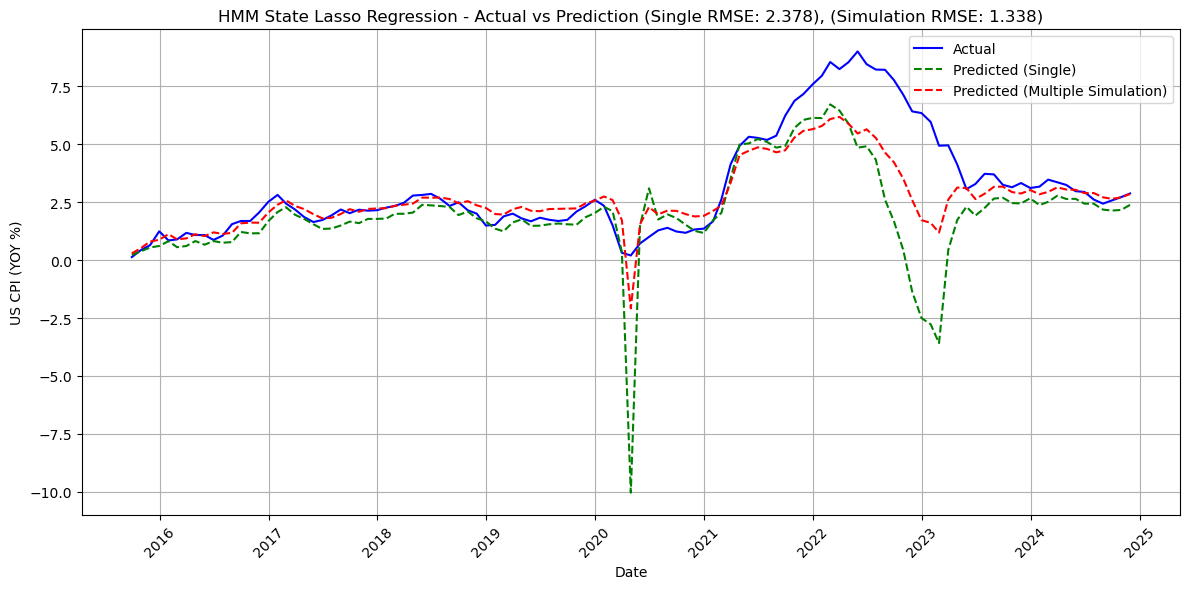

In [33]:
plt.figure(figsize=(12, 6))

test_dates = y_test.index

plt.plot(test_dates, y_test, 'b-', label='Actual')
plt.plot(test_dates, y_pred, 'g--', label='Predicted (Single)')
plt.plot(test_dates, y_pred_sim, 'r--', label='Predicted (Multiple Simulation)')
plt.xlabel('Date')
plt.ylabel('US CPI (YOY %)')
plt.title('HMM State Lasso Regression - Actual vs Prediction (Single RMSE: {}), (Simulation RMSE: {})'.format(hmm_lasso_rmse, hmm_lasso_sim_rmse))
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5. Sparse Regression with Horseshoe Prior

#### Assumptions
- Linear regression with strong shrinkage on irrelevant features and minimal shrinkage on large signals.

#### Hierarchical Prior
- For each coefficient:
  $$
  \beta_j \sim \mathcal{N}(0, \lambda_j^2 \tau^2)
  $$
  $$
  \lambda_j \sim \text{C}^+(0, 1), \quad \tau \sim \text{C}^+(0, 1)
  $$
  - C+ is the **half-Cauchy distribution**, which has heavy tails.

#### Likelihood
- The regression model:
  $$
  y_i \sim \mathcal{N}(\mathbf{x}_i^T \boldsymbol{\beta}, \sigma^2)
  $$

#### Key Features
- **Global-local shrinkage**:
  - tau: global shrinkage across all features.
  - lambda: local scaling that allows individual large coefficients to escape shrinkage.
- Stronger sparsity than ridge/lasso

In [34]:
n,p = X_train_scaled.shape

In [35]:
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1,1)).flatten()

In [36]:
with pm.Model() as horseshoe_model:
    # Global shrinkage prior
    tau = pm.HalfCauchy('tau', beta=1)

    # Local shrinkage priors (one per regressor)
    lambda_ = pm.HalfCauchy('lambda_', beta=1, shape=p)
    
    # Coefficients with Horseshoe prior
    sigma_beta = pm.Deterministic('sigma_beta', tau * lambda_)
    beta = pm.Normal('beta', mu=0, sigma=sigma_beta, shape=p)

    # Intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    # Observation noise
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Linear model
    mu = intercept + pm.math.dot(X_train_scaled, beta)
    
    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y_train_scaled)
    
    # Inference
    approx = pm.fit(method='advi', n=20000)
    trace = approx.sample(2000)

Output()

Finished [100%]: Average Loss = -50.723


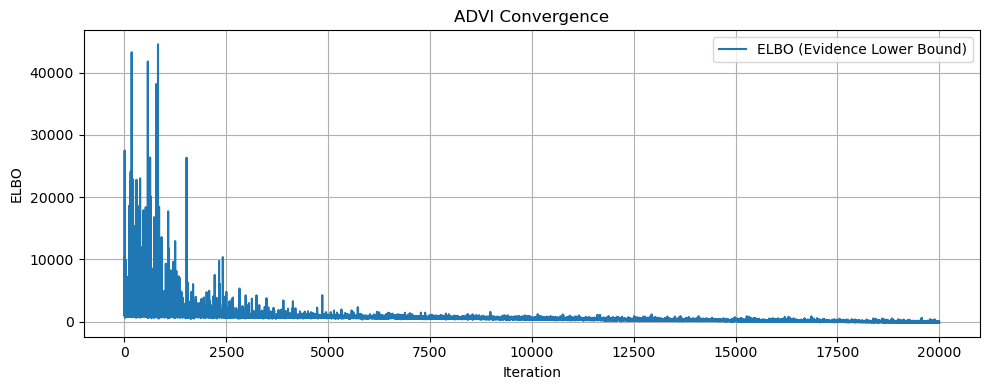

In [37]:
plt.figure(figsize=(10, 4))
plt.plot(approx.hist, label="ELBO (Evidence Lower Bound)")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.title("ADVI Convergence")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [38]:
horseshoe_model

       tau ~ HalfCauchy(0, 1)
   lambda_ ~ HalfCauchy(0, 1)
      beta ~ Normal(0, sigma_beta)
 intercept ~ Normal(0, 1)
     sigma ~ HalfNormal(0, 1)
sigma_beta ~ Deterministic(f(lambda_, tau))
     y_obs ~ Normal(f(intercept, beta), sigma)

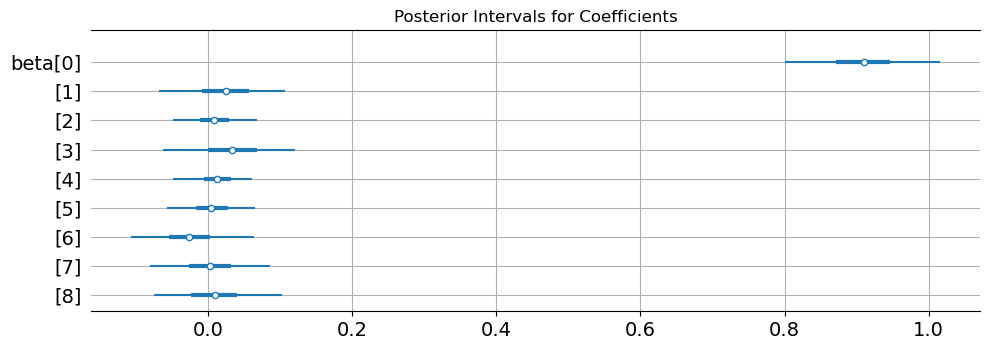

In [39]:
az.plot_forest(trace, var_names=["beta"], combined=True, figsize=(10, p * 0.4))
plt.title("Posterior Intervals for Coefficients")
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
# Get posterior samples of coefficients
beta_samples = trace.posterior["beta"].stack(sample=("chain", "draw")).values

# Mean or median of each coefficient
beta_mean = beta_samples.mean(axis=1)
beta_median = np.median(beta_samples, axis=1)

# Optional: get intercept too
intercept_samples = trace.posterior["intercept"].stack(sample=("chain", "draw")).values
intercept_mean = intercept_samples.mean()

# Put into a DataFrame with feature names
coeff_df = pd.DataFrame({
    "feature": X_train.columns,
    "beta_mean": beta_mean,
    "beta_median": beta_median
})

# Sort by absolute size of mean coefficient
coeff_df["abs_beta"] = np.abs(coeff_df["beta_mean"])
coeff_df.sort_values("abs_beta", ascending=False, inplace=True)

# Show top coefficients
coeff_df.drop(columns="abs_beta").head(10)


,feature,beta_mean,beta_median
0,CPI_YOY,0.909523,0.910091
3,PCE_YOY,0.033467,0.033454
6,Yield_Curve_1Y_Avg,-0.024912,-0.025971
1,PPI_YOY,0.024274,0.024354
4,Inflation_Expectations_YOY,0.012312,0.012798
2,NFP_MOM,0.008950,0.008451
8,Federal_Spending_5Y_Change,0.008545,0.009513
5,FedFunds_Rate_YOY,0.004257,0.004397
7,M2_5Y_Change,0.003117,0.003069


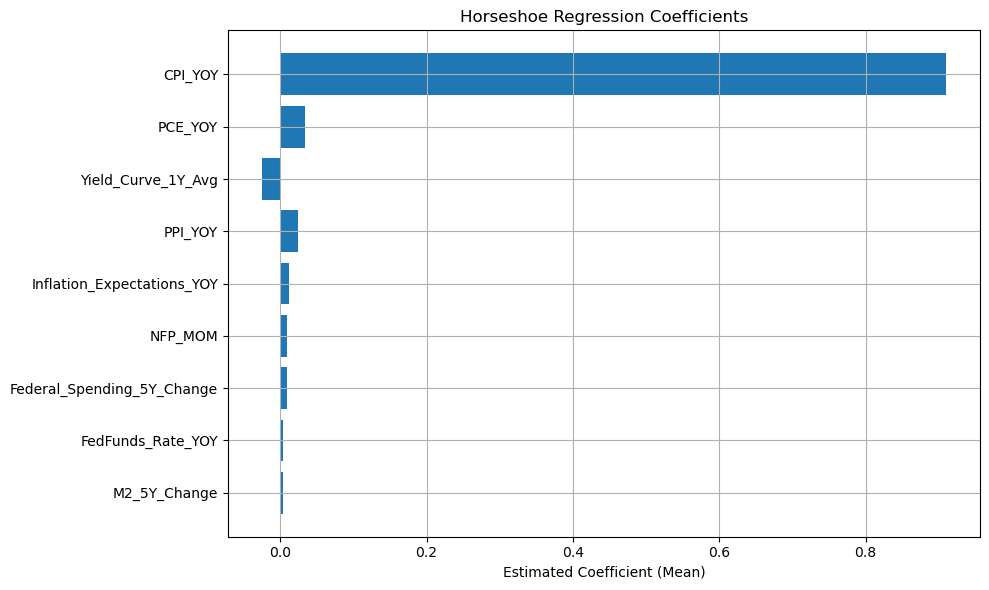

In [41]:
plt.figure(figsize=(10, 6))
plt.barh(coeff_df["feature"], coeff_df["beta_mean"])
plt.xlabel("Estimated Coefficient (Mean)")
plt.title("Horseshoe Regression Coefficients")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
# Compute predicted y using posterior draws
posterior_beta = trace.posterior["beta"].stack(samples=("chain", "draw")).values
posterior_intercept = trace.posterior["intercept"].stack(samples=("chain", "draw")).values

# Predict y using X_scaled
y_pred_scaled_samples = X_test_scaled @ posterior_beta + posterior_intercept

# Take the mean prediction across samples
y_pred_scaled_mean = y_pred_scaled_samples.mean(axis=1)

# Inverse transform to original y units
y_pred = scaler.inverse_transform(y_pred_scaled_mean.reshape(-1, 1)).flatten()

In [43]:
# Calculate RMSE
horseshoe_rmse = np.round(np.sqrt(mean_squared_error(y_test, y_pred)),3)
print(horseshoe_rmse)

0.569


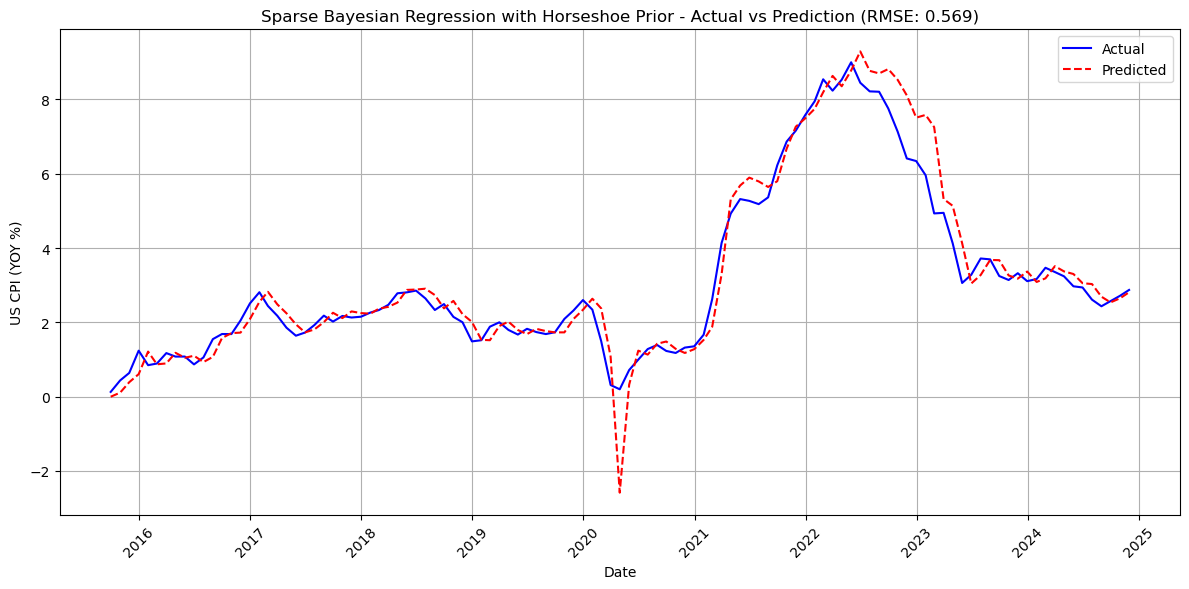

In [44]:
plt.figure(figsize=(12, 6))

test_dates = y_test.index

plt.plot(test_dates, y_test, 'b-', label='Actual')
plt.plot(test_dates, y_pred, 'r--', label='Predicted')
plt.xlabel('Date')
plt.ylabel('US CPI (YOY %)')
plt.title('Sparse Bayesian Regression with Horseshoe Prior - Actual vs Prediction (RMSE: {})'.format(horseshoe_rmse))
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Comparison of Results

In [45]:
model_names = ['Linear Regression',
               'Lasso Regression',
               'Gaussian Process Regression',
               'Hidden Markov State Switching Model',
               'Sparse Regression with Horseshoe Prior']

rmse_values = [reg_rmse,
               lasso_rmse,
               gp_rmse,
               hmm_lasso_sim_rmse,
               horseshoe_rmse]

results_df = pd.DataFrame({'Model': model_names,
                           'RMSE' : rmse_values })

results_df = results_df.sort_values(by='RMSE', ascending=True).reset_index(drop=True)

results_df

,Model,RMSE
0,Lasso Regression,0.375
1,Sparse Regression with Horseshoe Prior,0.569
2,Gaussian Process Regression,0.687
3,Linear Regression,0.692
4,Hidden Markov State Switching Model,1.338
